In [1]:
########################################################################
# Team Flat Earth Society: Brock Wallin, Lucas Clatterbaugh, Daniel Weatherspoon, Connor Gloden
# AST 304, Fall 2022
# Michigan State University
########################################################################

In [2]:
# importing necessary functions and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import astro_const as ac
from eos import mean_molecular_weight
from structure import (central_thermal,stellar_derivatives,central_values,lengthscales,integrate)
from zams import (Teff, surface_luminosity)
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# testing modules
!python testing.py

chemistry passed testing
adiabatic EOS passed testing
reactions passed testing
central temperature passed testing
effective temperature passed testing
surface luminosity passed testing


In [4]:
# initial conditions, verified
delta_m = 1e-35   # Msun
r0 = 1e-9   # Rsun

xi = 0.05
eta = 1e-20
XH = 0.706
pp_factor = 1

# for mu calc
Z = np.array([1, 2, 7])
A = np.array([1, 4, 14])
X = np.array([XH, 0.275, 0.019])

# solving for mu
mu = mean_molecular_weight(Z,A,X)

# wanted mass to go through
M_want = np.linspace(0.1, 0.3, 10)

# initializing radius array and making radius guess
R_out = np.zeros(len(M_want))
R_guess = 0.3

# function to use in rootfinding, finds true final radius given mass
def rad_func(R_guess, M, delta_m, eta, xi, mu, XH, pp_factor):
    Pc, rhoc, Tc = central_thermal(M, R_guess, mu)
    m, r, p, L = integrate(Pc, rhoc, Tc, delta_m, eta, xi, mu, XH, pp_factor)
    val = L[-1] - surface_luminosity(Teff(M), R_guess*ac.Rsun)
    return val

# runs rootfinding for 10 given masses
# output is in Rsun units
for i in range(len(M_want)):
    R_out[i] = brentq(rad_func, a = 1e-2, b = 1, xtol = 1e-4, 
                       args = (M_want[i], delta_m, eta, xi, mu, XH, pp_factor))

In [5]:
# initializing output dictionary
output_dict = {}
out_centrals = []

# integration loop
for j in range(len(M_want)):
    # initializing dataframe
    df = pd.DataFrame(columns = ["Mass(kg)", "Radius(m)", "Pressure(Pa)", "Luminosity(W)"])
    
    # performing integration
    Pc, rhoc, Tc = central_thermal(M_want[j],R_out[j],mean_molecular_weight(Z,A,X))
    m_out, r_out, p_out, L_out = integrate(Pc,rhoc,Tc,delta_m,eta,xi,mu,XH,pp_factor)
    
    # saving central values for plotting later
    out_centrals.append([rhoc, Tc])
    
    # saving arrays to dataframe
    df["Mass(kg)"] = m_out
    df["Radius(m)"] = r_out
    df["Pressure(Pa)"] = p_out
    df["Luminosity(W)"] = L_out
    
    #saving dataframe to dictionary so all data is easy to access in one location
    output_dict[j] = df

# converting central list to array for use
out_centrals = np.array(out_centrals)

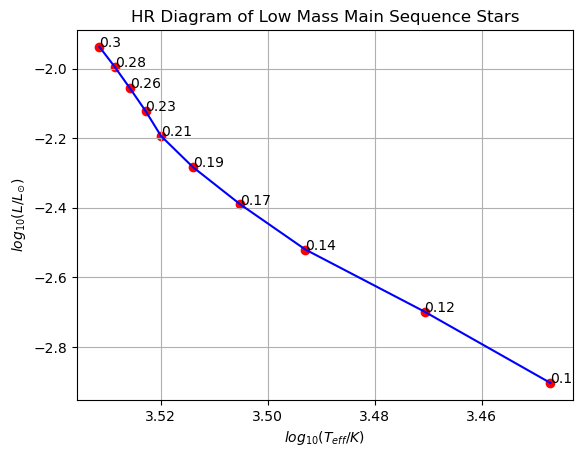

In [6]:
# initializing temp and lum arrays
Teff_arr = np.zeros([len(M_want)])
Lum_arr = np.zeros([len(M_want)])

# personal Teff function to avoing interpolation
def Teff_real(i):
    Teff = (output_dict[i].iloc[-1,3]/(ac.fourpi*ac.sigmaSB*output_dict[i].iloc[-1,1]**2))**(1/4)
    return Teff

# solving Teff and lum in log10 scale
for i in range(len(M_want)):
    Teff_arr[i] = np.log10(Teff_real(i))
    Lum_arr[i] = np.log10(output_dict[i].iloc[-1,3]/ac.Lsun)

# plotting HR diagram using output data
plt.plot(Teff_arr, Lum_arr, c = "b")
plt.scatter(Teff_arr, Lum_arr, c = "r")
plt.title("HR Diagram of Low Mass Main Sequence Stars")
plt.xlabel("$log_{10}(T_{eff}/K)$")
plt.ylabel("$log_{10}(L/L_{\odot})$")
plt.gca().invert_xaxis() 
plt.grid()

# annotating each point with correct mass
for j in range(len(Lum_arr)):
    plt.annotate(np.round(M_want[j],2), (Teff_arr[j], Lum_arr[j]))

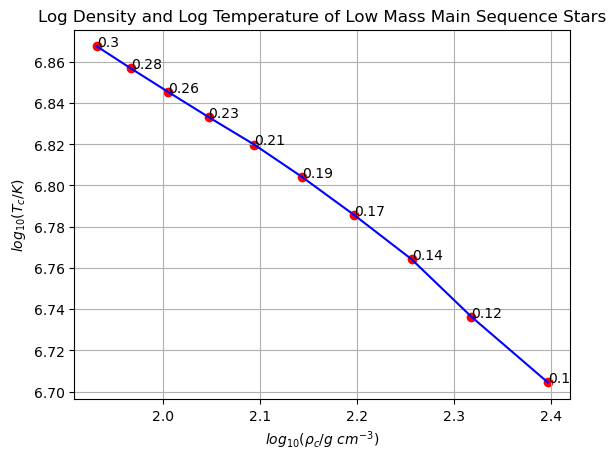

In [7]:
# setting density and temperature arrays in egs
den = out_centrals[:,0] * 0.001
temp = out_centrals[:,1]

# plotting figure similar to Figure 16 in Paxton et al. (2011)
plt.plot(np.log10(den), np.log10(temp), c = "b")
plt.scatter(np.log10(den), np.log10(temp), c = "r")
plt.title("Log Density and Log Temperature of Low Mass Main Sequence Stars")
plt.ylabel("$log_{10}(T_{c}/K)$")
plt.xlabel("$log_{10}(ρ_{c}/g\ cm^{-3})$")
plt.grid()

# annotating each point with correct mass
for j in range(len(temp)):
    plt.annotate(np.round(M_want[j],2), (np.log10(den[j]), np.log10(temp[j])))

The point when L(r) is at 90% of its value is: 0.395 r/R
The point when L(m) is at 90% of its value is: 0.272 m/M


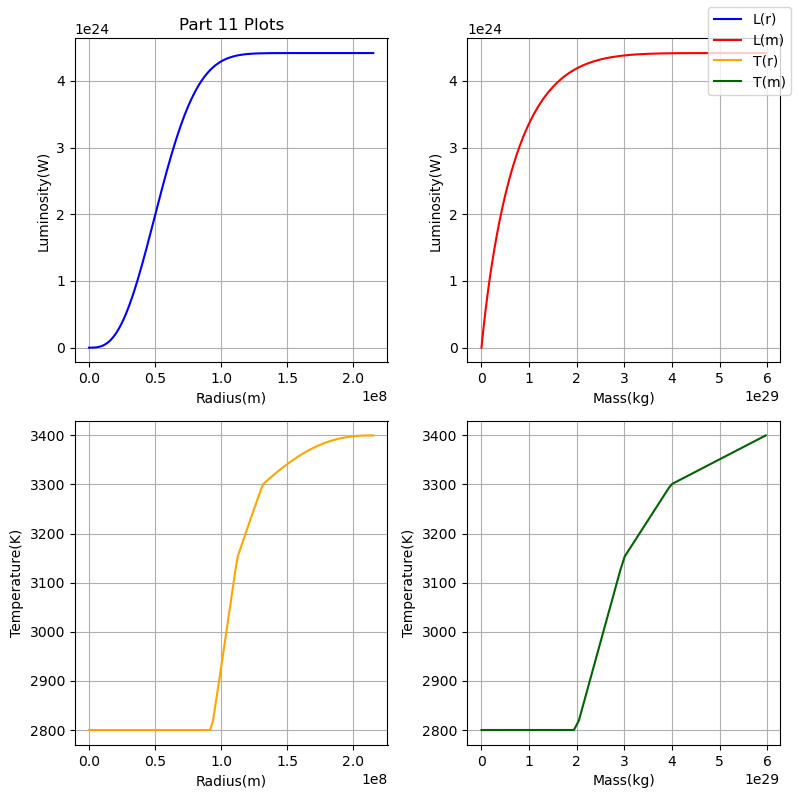

In [8]:
# getting various arrays from output for plotting part 2.11
radius_arr = np.array(output_dict[9]["Radius(m)"])
mass_arr = np.array(output_dict[9]["Mass(kg)"])
Lum_arr = np.array(output_dict[9]["Luminosity(W)"])
T_arr = Teff(mass_arr/ac.Msun)

# solving where luminosity reaches 90% max value
L_index = min(np.where(Lum_arr > 0.9*max(Lum_arr))[0])

# initializing suubplots
fig, ax = plt.subplots(2, 2, figsize = (8,8))

# plotting L(r)
ax[0,0].set_title("Part 11 Plots")
ax[0,0].plot(radius_arr, Lum_arr, c = "b", label = "L(r)")
ax[0,0].set_xlabel("Radius(m)")
ax[0,0].set_ylabel("Luminosity(W)")
ax[0,0].grid()

# plotting L(m)
ax[0,1].plot(mass_arr, Lum_arr, c = "r", label = "L(m)")
ax[0,1].set_xlabel("Mass(kg)")
ax[0,1].set_ylabel("Luminosity(W)")
ax[0,1].grid()

# plotting T(r)
ax[1,0].plot(radius_arr, T_arr, c = "orange", label = "T(r)")
ax[1,0].set_xlabel("Radius(m)")
ax[1,0].set_ylabel("Temperature(K)")
ax[1,0].grid()

# plotting T(m)
ax[1,1].plot(mass_arr, T_arr, c = "darkgreen", label = "T(m)")
ax[1,1].set_xlabel("Mass(kg)")
ax[1,1].set_ylabel("Temperature(K)")
ax[1,1].grid()

fig.legend()
fig.tight_layout()

# fiding r/R and m/M and printing values
Lr90 = radius_arr[L_index]/radius_arr[-1]
Lm90 = mass_arr[L_index]/mass_arr[-1]

print("The point when L(r) is at 90% of its value is:", np.round(Lr90,3), "r/R")
print("The point when L(m) is at 90% of its value is:", np.round(Lm90,3), "m/M")

In [9]:
# changing pp_factor to see effect on star
new_pp_factor = 1e5
new_R_out = np.zeros(len(M_want))

# all code below is rerunning integration with new pp_factor
for i in range(len(M_want)):
    new_R_out[i] = brentq(rad_func, a = 1e-2, b = 1, xtol = 1e-4, 
                       args = (M_want[i], delta_m, eta, xi, mu, XH, new_pp_factor))

new_out_dict = {}

for j in range(len(M_want)):
    df = pd.DataFrame(columns = ["Mass(kg)", "Radius(m)", "Pressure(Pa)", "Luminosity(W)"])
    
    Pc, rhoc, Tc = central_thermal(M_want[j],new_R_out[j],mean_molecular_weight(Z,A,X))
    m_out, r_out, p_out, L_out = integrate(Pc,rhoc,Tc,delta_m,eta,xi,mu,XH,new_pp_factor)
    
    # saving arrays to dataframe
    df["Mass(kg)"] = m_out
    df["Radius(m)"] = r_out
    df["Pressure(Pa)"] = p_out
    df["Luminosity(W)"] = L_out
    
    # saving dataframe to dictionary so all data is easy to access in one location
    new_out_dict[j] = df

In [10]:
# comparing old radius and luminosity to new values calculated
# with larger pp_factor
old_R = np.zeros(len(output_dict))
old_L = np.zeros(len(output_dict))

new_R = np.zeros(len(output_dict))
new_L = np.zeros(len(output_dict))

# saving arrays of final L and r from both integration runs
for k in range(len(output_dict)):
    old_R[k] = output_dict[k].iloc[-1,1]
    old_L[k] = output_dict[k].iloc[-1,3]
    
    new_R[k] = new_out_dict[k].iloc[-1,1]
    new_L[k] = new_out_dict[k].iloc[-1,3]

# new values is with higher pp_factor, old values is
# with pp_factor = 1
R_ratio = new_R/old_R
L_ratio = new_L/old_L

# putting results into df and showing
comp_df = pd.DataFrame([R_ratio, L_ratio], columns = np.round(M_want,2), 
                       index = ["$R_{new}$ / $R_{old}$", "$L_{new}$ / $L_{old}$"])
comp_df = comp_df.transpose().rename_axis("Mass($M_{\odot}$)", axis = 1)

comp_df

Mass($M_{\odot}$),$R_{new}$ / $R_{old}$,$L_{new}$ / $L_{old}$
0.10,2.531973,6.411466
0.12,2.565044,6.579527
0.14,2.594596,6.726984
0.17,2.617558,6.851930
0.19,2.637346,6.960409
0.21,2.654695,7.047202
0.23,2.669332,7.127062
0.26,2.683208,7.194365
0.28,2.695838,7.265391
0.30,2.707729,7.332481


## Report

#### 2.1
![output_table.png](output_table.png)

The table above is the results from project 2, verifying the correct relationships between the central pressure, central density, and their average values. Before updating and implementing methods and functions into the previous project 2 code, we first tested the K value found in the equation of state: 

$$ 
P = Kρ^\frac{5}{3} 
$$ 

By using the central pressure and density from our white dwarf model and multiplying the K value above by both 0.5 and 2, we found that the resulting relationship was within an acceptable magnitude that would not affect our overall results. 

#### Testing 
In the first cell after the imports above, we test all the test python files and see that all of them pass without error. We have also tested our values of $\eta$, $\xi$, and $\delta_{m}$ to be sufficiently small as to not affect our results if we were to vary each of these slightly. We have also tried to make these values reasonably small and tried not to make them too small to waste computational time. We can verify this by looking at the last several lines of our output data nested in our output dictionary. 

#### 2.10 
Above, we have constructed two plots that match **Figure 15 & 16** from Paxton et al. (2011). In both diagrams, we have simulated 10 stars with mass $0.1 -> 0.3 M_{\odot}$ all evenly spaced by $0.033 M_{\odot}$. This gives us $10$ points on each plot, each labeled with their corresponding mass. We can see that both the scale of the plots and the general shape closely match what is in Paxton et al. (2011), verifying that our code is working as intended. 

#### 2.11 
We also show four plots representing the luminosity and temperature as functions of radius and mass as we work our way from the inside to the outside of a $0.3\ M_{\odot}$ star. We have also calculated the value of $r/R$ and $m/M$ corresponding to the point in the star when we have reached $90%$ of the maximum luminosity, these values being $0.395$ and $0.272$ respectively. This means that 90% of the total surface luminosity of the star occurs 39.5% of the way out of the star going by radius measurements, which encompasses $27.2%$ of the stars total mass, meaning the luminosity does not change very much for most of the star. 

#### 3 
If we change the pp_factor rate from $1$ to $10^5$, we can see in our comparison table that with the larger pp_factor, the radius is about $3$ times and the luminosity is about $10$ times that of the star with the smaller pp_factor of $1$ if we round to one significant figure in both cases. In more general terms, this means that the star gets slightly larger and much brighter. If we were to apply this logic to the Sun, then the Earth would absorb $10$ times as much energy from the Sun, and terrestrial temperatures would increase from this. If we take a rough estimate using the mean kinetic energy of all the particles in the Earth's atmosphere, this would amount to an increase in temperature by an entire order of magnitude, bringing the average temperature well over the boiling point of water and thus making Earth completely inhospitable for life. 